In [1]:
%matplotlib inline
from pprint import pprint

import matplotlib.pyplot as plt
import nivapy3 as nivapy
import numpy as np
import pandas as pd
import seaborn as sn
import utils
from joblib import dump, load
from matplotlib import colors
from osgeo import gdal
from skimage import exposure
from skimage.util import img_as_ubyte
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

sn.set(style="ticks")
plt.style.use("ggplot")

## 1. Training on a single image

### 1.1. Get samples dataframe

In [3]:
# Area of interest
area = 1

# Get samples
df = utils.image_to_sample_df(area, equalise=False)

# Split into training and evaluation
cols = [str(i) for i in range(1, 6)]
X_train, X_eval, y_train, y_eval = train_test_split(
    df[cols],
    df["y"],
    test_size=0.4,
    random_state=42,
)

# Checking
assert len(X_train) == len(y_train)
assert len(X_eval) == len(y_eval)
print("Number of training samples:  ", len(X_train))
print("Number of evaluation samples:", len(X_eval))

df.head()

Number of training samples:   1054317
Number of evaluation samples: 702878


,y,1,2,3,4,5
0,1,5,6,9,5,4
1,1,4,6,9,5,4
2,1,4,6,8,5,4
3,1,4,6,8,5,4
4,1,4,6,9,5,4


### 1.2. Evaluate "basic" classifier

In [4]:
%%time

# Train on 60% of data
base_model = RandomForestClassifier(
    n_estimators=10,
    max_depth=20,
    random_state=42,
    n_jobs=-1,
)
base_model.fit(X_train, y_train)

CPU times: user 25.3 s, sys: 463 ms, total: 25.7 s
Wall time: 3.38 s


RandomForestClassifier(max_depth=20, n_estimators=10, n_jobs=-1,
                       random_state=42)

In [5]:
%%time

# Predict for remaining 40% of data
base_preds = base_model.predict(X_eval)

CPU times: user 2.42 s, sys: 198 ms, total: 2.62 s
Wall time: 427 ms


In [7]:
# Define classes and colours

# Class codes
class_codes = {
    -1: "Other",
    0: "No data",
    1: "Brown algae",
    2: "Green algae",
    3: "Red algae",
    4: "Eelgrass",
    5: "Rock",
    6: "Sand",
    7: "Lichen",
    8: "Lichen (2)",
    9: "Terrestrial vegetation",
    10: "Beach/shingle",
}

# Define colours for classes. Ordered -1 to 10 (i.e. same as in 'class_codes', above)
cmap = colors.ListedColormap(
    [
        "lightcyan",
        "black",
        "tan",
        "lawngreen",
        "red",
        "none",
        "lightgrey",
        "gold",
        "magenta",
        "none",
        "mediumseagreen",
        "orange",
    ]
)
bounds = np.arange(-1.5, 11.5)
norm = colors.BoundaryNorm(bounds, cmap.N)

In [8]:
# Only use relevant labels from the training dataset
class_labels = [1, 2, 3, 5, 6, 7, 9, 10]
class_names = [class_codes[i] for i in class_labels]

utils.classification_report(
    y_eval,
    base_preds,
    class_labels,
    class_names,
)

Classification report:
                        precision    recall  f1-score   support

           Brown algae       0.97      0.96      0.96    312667
           Green algae       0.47      0.19      0.27      5399
             Red algae       0.33      0.05      0.08      2564
                  Rock       0.85      0.94      0.89    240713
                  Sand       0.79      0.71      0.75     18264
                Lichen       0.48      0.09      0.15      6943
Terrestrial vegetation       0.85      0.79      0.82     63009
         Beach/shingle       0.85      0.79      0.82     53319

              accuracy                           0.90    702878
             macro avg       0.70      0.56      0.59    702878
          weighted avg       0.89      0.90      0.89    702878

Classification accuracy: 0.899728


<AxesSubplot:>

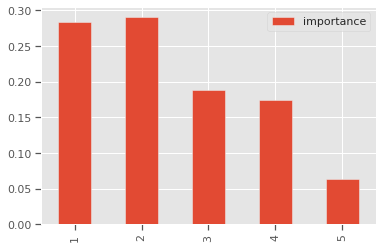

In [10]:
# Feature importances
imp_df = pd.DataFrame(
    {"importance": base_model.feature_importances_},
    index=range(1, 6),
)
imp_df.plot.bar()

### 1.3. Hyperparameter tuning

**Note:** The memory footprint of the forest increases linearly with the number of trees and exponentially with the `max_depth` parameter. The total size of the forest in memory can also easily become many times the size of the training dataset, so with large datasets (as here) it is easy to use *a lot* of memory. Including `max_depth=None`, as in the example below, will likely lead to very "deep" trees with a large memory footprint and/or memory errors.

If you do choose to run with `max_depth=None`, you can check the depth of the resulting forest using e.g.:

    depths = [tree.tree_.max_depth for tree in rf.estimators_]
    print(f"Mean tree depth in the Random Forest: {np.round(np.mean(depths))}.")
    print(f"Maximum tree depth in the Random Forest: {np.max(depths)}.")

In [11]:
# Number of trees in random forest
n_estimators = [10]

# Number of features to consider at every split
max_features = ["auto", "sqrt"]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num=4)]
max_depth.append(None)

# Create the random grid
random_grid = {
    "max_features": max_features,
    "max_depth": max_depth,
    "n_estimators": n_estimators,
}

pprint(random_grid)

{'max_depth': [10, 40, 70, 100, None],
 'max_features': ['auto', 'sqrt'],
 'n_estimators': [10]}


In [12]:
%%time
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(n_jobs=-1)

# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=random_grid,
    n_iter=100,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1,
)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 10 is smaller than n_iter=100. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


CPU times: user 30.5 s, sys: 929 ms, total: 31.4 s
Wall time: 1min 3s


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [10, 40, 70, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'n_estimators': [10]},
                   random_state=42, verbose=2)

In [13]:
%%time

best = rf_random.best_estimator_

# Predict classes for remaining 40% of data
best_preds = best.predict(X_eval)

CPU times: user 3.59 s, sys: 249 ms, total: 3.84 s
Wall time: 573 ms


In [14]:
print("The 'best' model identified has the following parameters:")
print(best)

utils.classification_report(
    y_eval,
    best_preds,
    class_labels,
    class_names,
)

The 'best' model identified has the following parameters:
RandomForestClassifier(max_depth=40, max_features='sqrt', n_estimators=10,
                       n_jobs=-1)
Classification report:
                        precision    recall  f1-score   support

           Brown algae       0.96      0.96      0.96    312667
           Green algae       0.43      0.22      0.29      5399
             Red algae       0.30      0.10      0.15      2564
                  Rock       0.86      0.93      0.89    240713
                  Sand       0.78      0.71      0.75     18264
                Lichen       0.39      0.10      0.16      6943
Terrestrial vegetation       0.84      0.78      0.81     63009
         Beach/shingle       0.85      0.78      0.81     53319

              accuracy                           0.90    702878
             macro avg       0.68      0.57      0.60    702878
          weighted avg       0.89      0.90      0.89    702878

Classification accuracy: 0.895796


## 2. Train "basic" model using images 1, 2 and 6

In [15]:
# Read image data
df_list = []
for area in [1, 2, 6]:
    # With equalisation
    df = utils.image_to_sample_df(area, equalise=False)
    df_list.append(df)

df = pd.concat(df_list, axis="rows")
del df_list

print("Number of training samples:  ", len(df))

df.head()

Number of training samples:   6259758


,y,1,2,3,4,5
0,1,5,6,9,5,4
1,1,4,6,9,5,4
2,1,4,6,8,5,4
3,1,4,6,8,5,4
4,1,4,6,9,5,4


In [16]:
%%time

# Train basic model
base_model = RandomForestClassifier(
    n_estimators=10,
    max_depth=20,
    random_state=42,
    n_jobs=-1,
)

cols = [str(i) for i in range(1, 6)]
base_model.fit(df[cols], df["y"])

CPU times: user 2min 32s, sys: 3.01 s, total: 2min 35s
Wall time: 19.1 s


RandomForestClassifier(max_depth=20, n_estimators=10, n_jobs=-1,
                       random_state=42)

<AxesSubplot:>

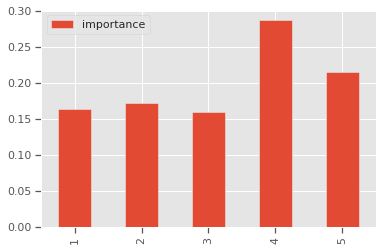

In [17]:
# Feature importances
imp_df = pd.DataFrame(
    {"importance": base_model.feature_importances_},
    index=range(1, 6),
)
imp_df.plot.bar()

## 3. Predict image 3

In [18]:
%%time

area = 3

im3_df = utils.image_to_sample_df(area, equalise=False)
base_preds = base_model.predict(im3_df[cols])

CPU times: user 4.6 s, sys: 542 ms, total: 5.14 s
Wall time: 1.43 s


In [19]:
utils.classification_report(
    im3_df["y"],
    base_preds,
    class_labels,
    class_names,
)

Classification report:
                        precision    recall  f1-score   support

           Brown algae       0.69      0.93      0.79    538277
           Green algae       0.29      0.17      0.22     10749
             Red algae       0.03      0.01      0.01      5013
                  Rock       0.77      0.94      0.85    482930
                  Sand       0.91      0.53      0.67    477763
                Lichen       0.03      0.01      0.02       861
Terrestrial vegetation       0.77      0.69      0.73    114860
         Beach/shingle       0.92      0.41      0.56    136525

              accuracy                           0.76   1766978
             macro avg       0.55      0.46      0.48   1766978
          weighted avg       0.79      0.76      0.75   1766978

Classification accuracy: 0.760483


In [20]:
# Convert maintaining original size (i.e. keep NoData)
im3_df = utils.image_to_sample_df(area, equalise=False, dropna=False)

# Predict image 3
im3_preds = base_model.predict(im3_df[cols])

# Set NoData in predictions
im3_preds[im3_df["y"] == 0] = 0

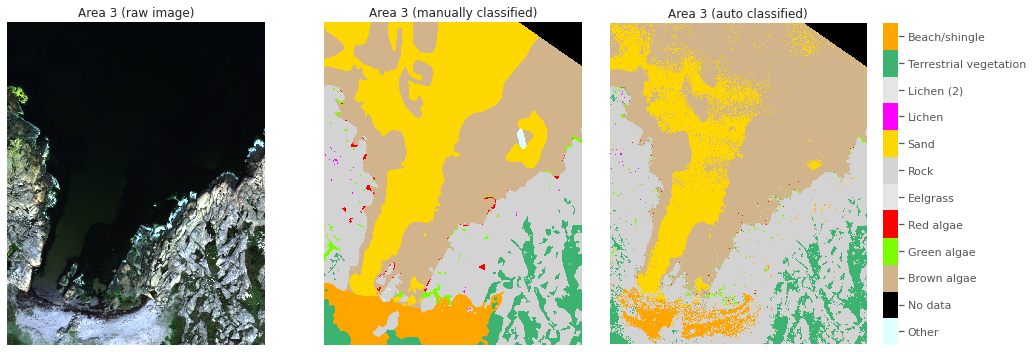

In [21]:
# Paths to images
raw_path = (
    f"/home/jovyan/shared/drones/frisk_oslofjord/harry_frisk_oslofjord_script/jes/raster/aligned/training/ne_akeroya_10cm_area_{area}.tif"
)
man_path = f"/home/jovyan/shared/drones/frisk_oslofjord/harry_frisk_oslofjord_script/jes/raster/aligned/training/ne_akeroya_10cm_area_{area}_man_class.tif"

# Read raw RGB bands to arrays
band1, ndv, epsg, extent = nivapy.spatial.read_raster(raw_path, band_no=1)
band2, ndv, epsg, extent = nivapy.spatial.read_raster(raw_path, band_no=2)
band3, ndv, epsg, extent = nivapy.spatial.read_raster(raw_path, band_no=3)
raw_img = np.dstack((band1, band2, band3))

# Read manual classification
man_img, ndv, epsg, extent = nivapy.spatial.read_raster(man_path, band_no=1)

# Reshape predictions
im3_preds = im3_preds.reshape(man_img.shape)

# Plot
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Raw image
axes[0].imshow(raw_img, interpolation="none")
axes[0].set_title(f"Area {area} (raw image)", fontsize=12)

# Manually classified
img = axes[1].imshow(man_img, cmap=cmap, norm=norm, interpolation="none")
axes[1].set_title(f"Area {area} (manually classified)", fontsize=12)

img = axes[2].imshow(im3_preds, cmap=cmap, norm=norm, interpolation="none")
axes[2].set_title(f"Area {area} (auto classified)", fontsize=12)

# Turn off axes
axes[0].axis("off")
axes[1].axis("off")
axes[2].axis("off")

# Colourbar for manual dataset
cb = plt.colorbar(img, ax=axes[2])
labels = np.arange(-1, 11)
cb.set_ticks(labels)
cb.set_ticklabels(list(class_codes.values()))

plt.tight_layout()

In [22]:
# Predict image 3 probs
im3_preds = base_model.predict_proba(im3_df[cols])

# Get max prob
im3_preds = im3_preds.max(axis=1)

# Set NoData in predictions
im3_preds[im3_df["y"] == 0] = np.nan

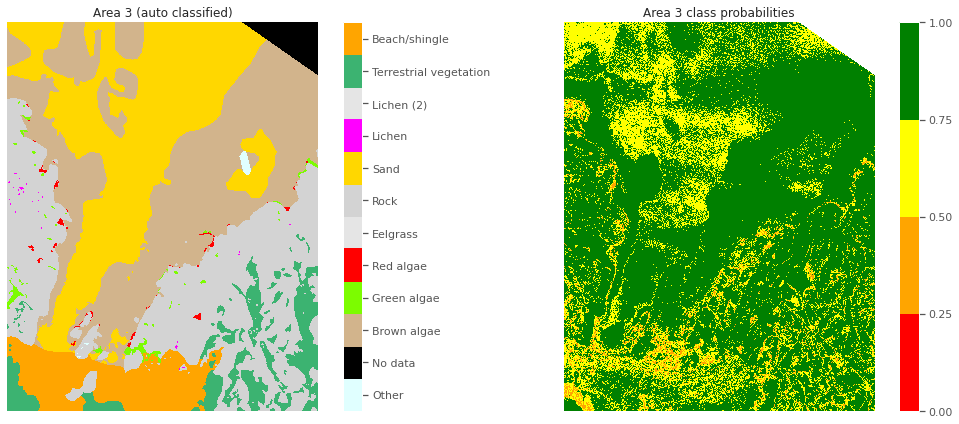

In [23]:
# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

colours = ["red", "orange", "yellow", "green"]
n_bin = 4  # Discretizes the interpolation into bins
n_bins_ranges = [0, 0.25, 0.5, 0.75, 1]
cmap_name = "probs"

# Create the colormap
cmap2 = colors.LinearSegmentedColormap.from_list(cmap_name, colours, N=n_bin)
norm2 = colors.BoundaryNorm(n_bins_ranges, len(n_bins_ranges))

# Manually classified
img = axes[0].imshow(man_img, cmap=cmap, norm=norm, interpolation="none")
axes[0].set_title(f"Area {area} (auto classified)", fontsize=12)

# Reshape predictions
im3_preds = im3_preds.reshape(man_img.shape)
img2 = axes[1].imshow(im3_preds, cmap=cmap2, norm=norm2, interpolation="none")
axes[1].set_title(f"Area {area} class probabilities", fontsize=12)

# Turn off axes
axes[0].axis("off")
axes[1].axis("off")

# Colourbar for manual dataset
cb = plt.colorbar(img, ax=axes[0])
labels = np.arange(-1, 11)
cb.set_ticks(labels)
cb.set_ticklabels(list(class_codes.values()))

# Colourbar for confidence
cb = plt.colorbar(img2, ax=axes[1])
cb.set_ticks(n_bins_ranges)
# cb.set_ticklabels(list(class_codes.values()))

plt.tight_layout()

## 4. Train basic model using all images

In [24]:
# Read image data
df_list = []
for area in range(1, 7):
    df = utils.image_to_sample_df(area, equalise=False)
    df_list.append(df)

df = pd.concat(df_list, axis="rows")
del df_list

print("Number of training samples:  ", len(df))

df.head()

Number of training samples:   12257269


,y,1,2,3,4,5
0,1,5,6,9,5,4
1,1,4,6,9,5,4
2,1,4,6,8,5,4
3,1,4,6,8,5,4
4,1,4,6,9,5,4


In [25]:
%%time

# Train basic model
base_model = RandomForestClassifier(
    n_estimators=10,
    max_depth=20,
    random_state=42,
    n_jobs=-1,
)

cols = [str(i) for i in range(1, 6)]
base_model.fit(df[cols], df["y"])

CPU times: user 6min 39s, sys: 5.79 s, total: 6min 45s
Wall time: 47.8 s


RandomForestClassifier(max_depth=20, n_estimators=10, n_jobs=-1,
                       random_state=42)

<AxesSubplot:>

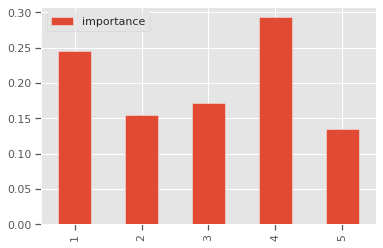

In [26]:
# Feature importances
imp_df = pd.DataFrame(
    {"importance": base_model.feature_importances_},
    index=range(1, 6),
)
imp_df.plot.bar()

In [27]:
out_path = r"/home/jovyan/shared/drones/frisk_oslofjord/harry_frisk_oslofjord_script/jes/base_model.joblib"
dump(base_model, out_path)

['/home/jovyan/shared/drones/frisk_oslofjord/harry_frisk_oslofjord_script/jes/base_model.joblib']

## 5. Predict "full" image

In [28]:
out_path = r"/home/jovyan/shared/drones/frisk_oslofjord/harry_frisk_oslofjord_script/jes/base_model.joblib"
base_model = load(out_path)

In [29]:
# Path to image
raw_path = f"/home/jovyan/shared/drones/frisk_oslofjord/harry_frisk_oslofjord_script/jes/raster/aligned/akeroya_ms_all_8bit.tif"

# Container for data
data_dict = {}

# Read raw bands to arrays
for band in range(1, 6):
    data, ndv, epsg, extent = nivapy.spatial.read_raster(raw_path, band_no=band)
    data_dict[str(band)] = data.flatten()

# Build df
df = pd.DataFrame(data_dict)
del data_dict

df.reset_index(inplace=True, drop=True)

print(f"The dataset contains {len(df) / 1e6} million samples.")

The dataset contains 426.76 million samples.


In [30]:
%%time

# Predict
cols = [str(i) for i in range(1, 6)]

chunk_res = []
chunks = np.array_split(df, 30)

for chunk in chunks:
    chunk_res.append(base_model.predict(chunk[cols]))

all_preds = np.concatenate(chunk_res)

CPU times: user 13min 42s, sys: 3min 5s, total: 16min 47s
Wall time: 3min 20s


In [31]:
# Get snap grid
data, ndv, epsg, extent = nivapy.spatial.read_raster(raw_path, band_no=1)

# Reshape predictions
all_preds = all_preds.reshape(data.shape)

# Set NoData in predictions
all_preds[data == 0] = 0

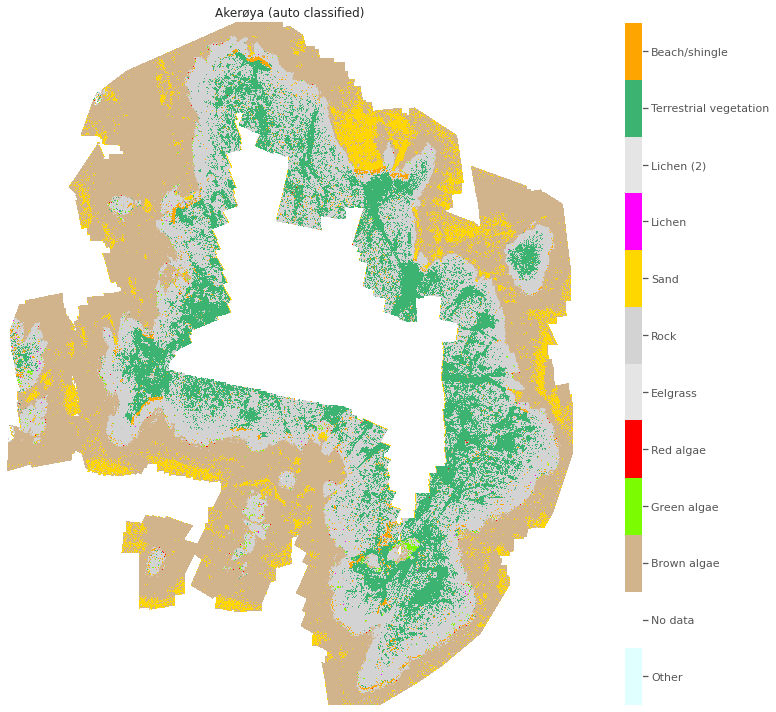

In [32]:
# Plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
img = ax.imshow(all_preds, cmap=cmap, norm=norm, interpolation="none")
ax.set_title(f"Akerøya (auto classified)", fontsize=12)
ax.axis("off")

cb = plt.colorbar(img, ax=ax, aspect=40)
labels = np.arange(-1, 11)
cb.set_ticks(labels)
cb.set_ticklabels(list(class_codes.values()))

plt.tight_layout()

In [33]:
# Save to geotiff
out_path = f"/home/jovyan/shared/drones/frisk_oslofjord/harry_frisk_oslofjord_script/jes/raster/aligned/akeroya_ms_all_8bit_auto_class.tif"
nivapy.spatial.array_to_gtiff(
    extent[0],
    extent[-1],
    0.10,
    out_path,
    all_preds,
    "+proj=utm +zone=32 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs",
    0,
    bit_depth="Int16",
)